Convert question to SQL query

In [3]:
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [7]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langchainhub langgraph

Application state

In [34]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

Select Model

In [11]:
!pip install -qU "langchain[groq]"

In [16]:
from secret_keys import groq_key
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = groq_key 


from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-r1-distill-llama-70b", model_provider="groq")

We will pull a prompt from the Prompt Hub to instruct the model.

In [22]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

C:\Users\tirth\anaconda3\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's SQLDatabase object includes methods to help with this. Our write_query step will just populate these parameters and prompt a model to generate the SQL query:

In [36]:
from typing_extensions import Annotated

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str,...,"Syntatically valid SQL query."]

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect":db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input" : state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [38]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) FROM Employee;'}

Execute query

This is the most dangerous part of creating a SQL chain. Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution 

In [41]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL Query"""
    execute_query_tool = QuerySQLDatabaseTool(db = db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [43]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

Generate answer

Finally, our last step generates an answer to the question given the information pulled from the database:

In [51]:
def generate_answer(state: State):
    """Answer the question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return{"answer":response.content}
    

Orchestrating with LangGraph

Finally, we compile our application into a single graph object. In this case, we are just connecting the three steps into a single sequence.

In [54]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query,execute_query,generate_answer]
)
graph_builder.add_edge(START,"write_query")
graph = graph_builder.compile()

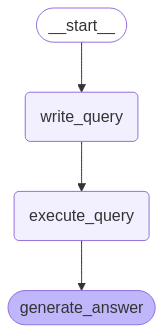

In [56]:
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(EmployeeId) FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '<think>\nOkay, so I need to figure out how to answer the user\'s question based on the information given. The user asked, "How many employees are there?" \n\nLooking at the SQL query provided, it\'s selecting the count of EmployeeId from the Employee table. That makes sense because counting the primary key (which is usually EmployeeId in such cases) would give the total number of employees. \n\nThe SQL result is given as [(8,)]. This is a tuple with a single value, 8. In Python, when you execute a SELECT COUNT query, it returns a tuple for each row, and since COUNT is an aggregate function, it returns just one row with one column. So the result here is 8.\n\nNow, to answer the user\'s question, I should take that number and present it clearly. I don\'t need to explain the SQL or the process unless the user asks for it. They just want the count, w

In [60]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

Human-in-the-loop

we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. This is enabled by LangGraph's persistence layer, which saves run progress to your storage of choice. Below, we specify storage in-memory:

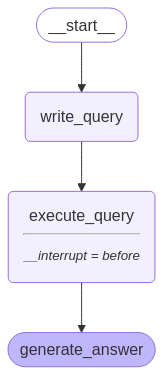

In [62]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee LIMIT 10;'}}
{'__interrupt__': ()}


Do you want to go to execute query? (yes/no):  no


Operation cancelled by user.
